In [ ]:
import torch

: 

In [2]:
from neural_verification import (
    Tokenizer, 
    TransformerConfig, 
    Transformer, 
    cycle,
    HeterogeneousDataLoader
)
from config import tokenizer_vocabulary, model_config

In [3]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = Transformer(model_config).to(device)

number of parameters: 6.345M


In [4]:
weights = torch.load('number_of_vowels_model.pt')
model.load_state_dict(weights)

<All keys matched successfully>

In [6]:
import numpy as np
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

In [5]:
torch.cuda.is_available()

True

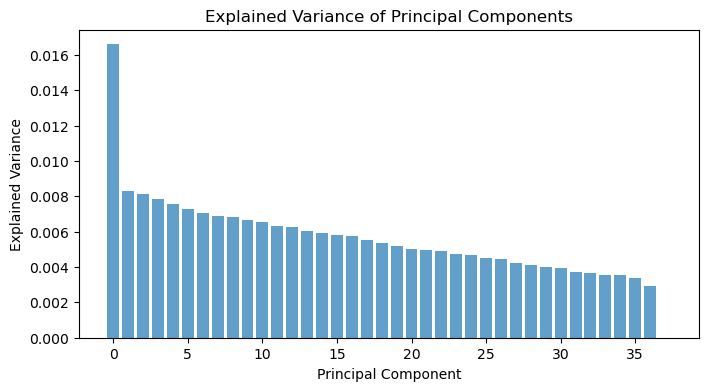

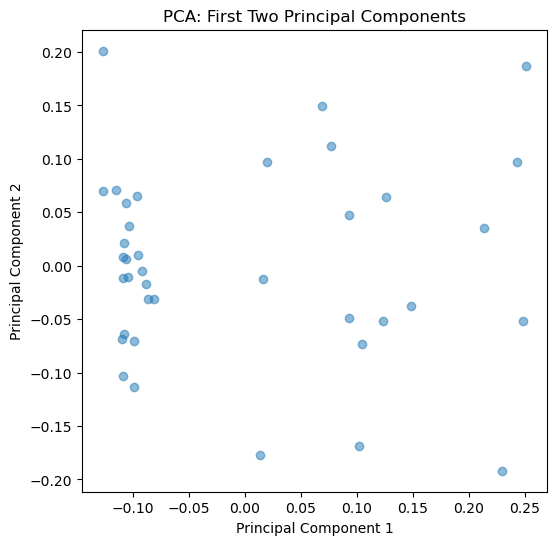

In [35]:

embeddings = model.transformer["wte"].weight.to(device)
letter_embeddings = embeddings[:26, :].to(device)

embeddings = embeddings.detach().to("cpu").numpy()
# Perform PCA
pca = PCA()
pca.fit(embeddings)

# Get the principal components and eigenvalues
principal_components = pca.components_
eigenvalues = pca.explained_variance_

# Visualize the explained variance
plt.figure(figsize=(8, 4))
plt.bar(range(len(eigenvalues)), eigenvalues, alpha=0.7)
plt.xlabel('Principal Component')
plt.ylabel('Explained Variance')
plt.title('Explained Variance of Principal Components')
plt.show()

# You can also use PCA to reduce dimensionality by specifying the number of components
n_components = 10  # Adjust the number of components as needed
pca = PCA(n_components=n_components)
reduced_matrix = pca.fit_transform(embeddings)

# 'reduced_matrix' now contains the data with reduced dimensions

# Optionally, you can visualize the first two principal components
if n_components >= 2:
    plt.figure(figsize=(6, 6))
    plt.scatter(reduced_matrix[:, 0], reduced_matrix[:, 1], alpha=0.5)
    plt.xlabel('Principal Component 1')
    plt.ylabel('Principal Component 2')
    plt.title('PCA: First Two Principal Components')
    plt.show()


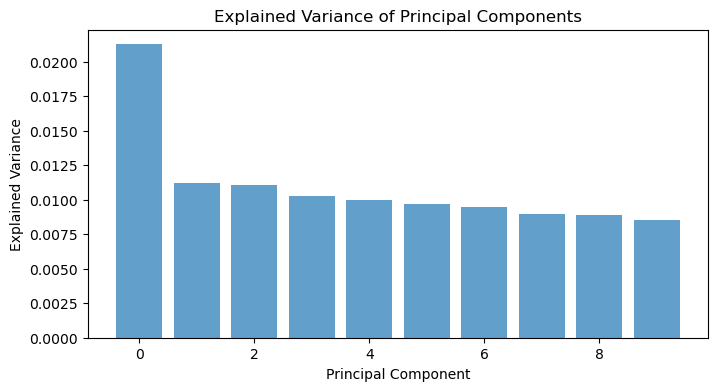

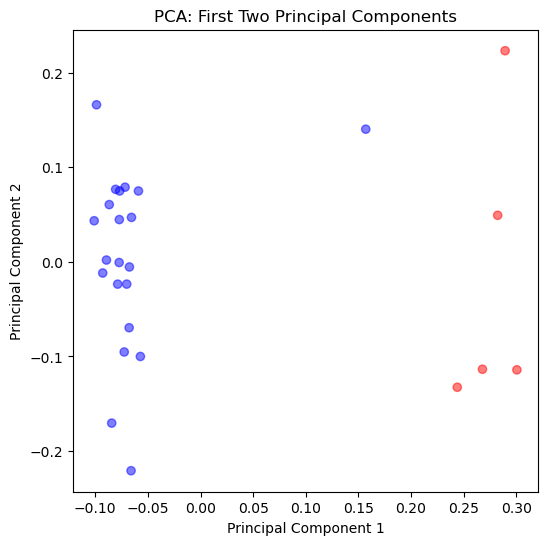

In [46]:

pca.fit(letter_embeddings)

# Get the principal components and eigenvalues
principal_components = pca.components_
eigenvalues = pca.explained_variance_

# Visualize the explained variance
plt.figure(figsize=(8, 4))
plt.bar(range(len(eigenvalues)), eigenvalues, alpha=0.7)
plt.xlabel('Principal Component')
plt.ylabel('Explained Variance')
plt.title('Explained Variance of Principal Components')
plt.show()

# You can also use PCA to reduce dimensionality by specifying the number of components
n_components = 10  # Adjust the number of components as needed
pca = PCA(n_components=n_components)
reduced_matrix = pca.fit_transform(letter_embeddings)

colors = ['r' if i in [1, 5, 9, 15, 21] else 'b' for i in range(26)]

# 'reduced_matrix' now contains the data with reduced dimensions

# Optionally, you can visualize the first two principal components
if n_components >= 2:
    plt.figure(figsize=(6, 6))
    plt.scatter(reduced_matrix[:, 0], reduced_matrix[:, 1], c=colors, alpha=0.5)
    plt.xlabel('Principal Component 1')
    plt.ylabel('Principal Component 2')
    plt.title('PCA: First Two Principal Components')
    plt.show()

In [8]:
tokenizer = Tokenizer(tokenizer_vocabulary)
tokens = tokenizer.encode("U")
print(tokens)

[21]


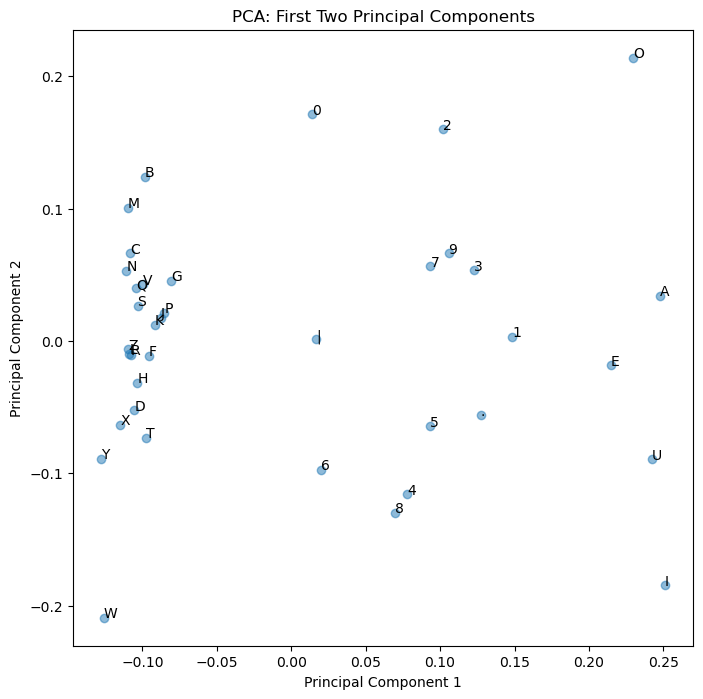

In [9]:
# embeddings = model.transformer["wte"].weight.to(device)

# embeddings = embeddings.detach().to("cpu").numpy()
# Perform PCA
pca = PCA()
pca.fit(embeddings)

# Get the principal components and eigenvalues
principal_components = pca.components_
eigenvalues = pca.explained_variance_


# You can also use PCA to reduce dimensionality by specifying the number of components
n_components = 10  # Adjust the number of components as needed
pca = PCA(n_components=n_components)
reduced_matrix = pca.fit_transform(embeddings)

# 'reduced_matrix' now contains the data with reduced dimensions

# Optionally, you can visualize the first two principal components
if n_components >= 2:
    plt.figure(figsize=(8, 8))
    plt.scatter(reduced_matrix[:, 0], reduced_matrix[:, 1], alpha=0.5)
    for i in range(len(reduced_matrix)):
        plt.text(reduced_matrix[i, 0], reduced_matrix[i, 1], tokenizer.decode(i))
    plt.xlabel('Principal Component 1')
    plt.ylabel('Principal Component 2')
    plt.title('PCA: First Two Principal Components')
    plt.show()

In [9]:
import pandas as pd
steps = 1500

def parse_tuple(string):
    """Parses a string representing a tuple of integers"""
    string = string[1:-1]
    split = string.split(",")
    if split[-1] == "":
        split = split[:-1]
    return tuple(map(int, split))

module_outputs = {}
module_inputs = {}

def named_hook_inputs(name):
    def hook_fn(module, input, output):
        module_inputs[name] = input[0].detach()
    return hook_fn

def named_hook_outputs(name):
    def hook_fn(module, input, output):
        module_outputs[name] = output.detach()
    return hook_fn
dataset = []
df = pd.read_csv("number_of_vowels_test.csv")
strings_test = df["string"].tolist()
answer_idxs_test = df["answer_idxs"].apply(parse_tuple).tolist()
test_loader = HeterogeneousDataLoader(strings_test, answer_idxs_test, batch_size=512, shuffle=True)
test_loader = cycle(test_loader)

for name, layer in model.named_modules():
    layer.register_forward_hook(named_hook_inputs(name))
    layer.register_forward_hook(named_hook_outputs(name))

# perform a forward pass and capture inputs and outputs of each layer
for step in range(steps):
    module_outputs = {}
    module_inputs = {}
    model.eval()
    with torch.inference_mode():
        # get a batch
        # forward pass
        batch_strings, batch_answer_idxs = next(test_loader)
        input_ids = tokenizer.encode(batch_strings, padding=True)
        input_ids = torch.tensor(input_ids).reshape((len(batch_strings), -1)).to(device)
        y = model(input_ids)
        dataset.append((batch_strings, module_outputs))
        

OutOfMemoryError: CUDA out of memory. Tried to allocate 44.00 MiB (GPU 0; 31.74 GiB total capacity; 30.79 GiB already allocated; 2.88 MiB free; 30.83 GiB reserved in total by PyTorch) If reserved memory is >> allocated memory try setting max_split_size_mb to avoid fragmentation.  See documentation for Memory Management and PYTORCH_CUDA_ALLOC_CONF

In [13]:
# load the data loader

dataset = []
df = pd.read_csv("number_of_vowels_test.csv")
strings_test = df["string"].tolist()
answer_idxs_test = df["answer_idxs"].apply(parse_tuple).tolist()
test_loader = HeterogeneousDataLoader(strings_test, answer_idxs_test, batch_size=512, shuffle=True)
test_loader = cycle(test_loader)



In [14]:
batch_strings, batch_answer_idxs = next(test_loader)

In [ ]:
def named_hook_inputs(name):
    def hook_fn(module, input, output):
        module_inputs[name] = input[0].detach()
    return hook_fn

def named_hook_outputs(name):
    def hook_fn(module, input, output):
        module_outputs[name] = output.detach()
    return hook_fn

for name, layer in model.named_modules():
    if "mlp" in name:
    layer.register_forward_hook(named_hook_inputs(name))
    layer.register_forward_hook(named_hook_outputs(name))

In [24]:
print(model.named_modules)

<bound method Module.named_modules of Transformer(
  (transformer): ModuleDict(
    (wte): Embedding(38, 512)
    (wpe): Embedding(12, 512)
    (drop): Dropout(p=0.0, inplace=False)
    (h): ModuleList(
      (0-1): 2 x Block(
        (ln_1): LayerNorm()
        (ln_2): LayerNorm()
        (attn): CausalSelfAttention(
          (c_attn): Linear(in_features=512, out_features=1536, bias=True)
          (c_proj): Linear(in_features=512, out_features=512, bias=True)
          (attn_dropout): Dropout(p=0.0, inplace=False)
          (resid_dropout): Dropout(p=0.0, inplace=False)
        )
        (mlp): MLPLayer(
          (c_fc): Linear(in_features=512, out_features=2048, bias=True)
          (gelu): GELU(approximate='none')
          (c_proj): Linear(in_features=2048, out_features=512, bias=True)
          (dropout): Dropout(p=0.0, inplace=False)
        )
      )
    )
    (ln_f): LayerNorm()
  )
  (lm_head): Linear(in_features=512, out_features=38, bias=False)
)>


In [56]:
print([name for (name, layer) in model.named_modules() if "mlp" in name ])

['transformer.h.0.mlp', 'transformer.h.0.mlp.c_fc', 'transformer.h.0.mlp.gelu', 'transformer.h.0.mlp.c_proj', 'transformer.h.0.mlp.dropout', 'transformer.h.1.mlp', 'transformer.h.1.mlp.c_fc', 'transformer.h.1.mlp.gelu', 'transformer.h.1.mlp.c_proj', 'transformer.h.1.mlp.dropout']


In [28]:
def count_number_of_vowels(string):
    vowels = ["A","E","I", "O", "U"]
    vs = [i for i in string if i in vowels]
    return len(vs)

print(count_number_of_vowels("TARA"))

2


In [36]:
del dataset

In [37]:
# Making probing dataset for mlp layer c_proj

# hooks to register
def named_hook_outputs(name):
    def hook_fn(module, input, output):
        module_outputs[name] = output.detach()
    return hook_fn

for name, layer in model.named_modules():
    if "mlp" in name and "c_proj" in name:
        layer.register_forward_hook(named_hook_outputs(name))

#get a batch

batch_strings, batch_answer_idxs = next(test_loader)

# create dataset

dataset = []


for i, datapoint in enumerate(batch_strings):
    model.eval()

    
    with torch.inference_mode():
        for j in range(1, len(datapoint) - 1):
            module_outputs = {}
            inp = datapoint[0:j]
            inp_ids = tokenizer.encode(inp, padding=True)
            inp_ids = torch.tensor(inp_ids).reshape((len(inp), -1)).to(device)
            y = model(inp_ids)
            dataset.append((module_outputs, count_number_of_vowels(inp)))



        
    

    

In [48]:
print(dataset[0][0]['transformer.wpe'])

tensor([[-2.5511e-02,  5.6783e-02, -7.7899e-03,  4.7247e-03,  1.7515e-03,
         -2.6286e-02,  1.8873e-02, -1.2259e-02,  3.2048e-02, -2.5690e-02,
          1.0147e-02,  2.3088e-03,  4.3529e-03, -1.1499e-02,  3.6441e-02,
          2.8255e-02, -2.8189e-02, -8.5549e-03,  3.4887e-02,  9.6417e-04,
         -7.9501e-04, -2.2710e-02,  1.1258e-02, -3.3540e-02,  4.5925e-02,
          8.0031e-03, -1.1960e-02,  9.3962e-03, -3.5339e-02,  2.2048e-02,
          6.2361e-04,  1.5216e-02, -9.4978e-03, -5.0317e-04,  2.3006e-02,
          8.2278e-03, -1.6330e-02, -4.2211e-03, -3.3097e-03, -4.4678e-03,
          5.4008e-02, -2.2146e-02,  5.9951e-03, -1.2539e-02, -3.8626e-04,
         -2.8254e-02,  1.5493e-02,  7.7706e-04,  2.8180e-02,  1.1805e-02,
         -2.0027e-02,  1.3054e-02, -1.1961e-02, -3.5388e-02, -8.8235e-03,
          1.0511e-02,  1.4400e-02, -3.7298e-02,  3.7091e-02,  1.5420e-02,
         -3.9979e-02, -1.9725e-02,  1.1780e-02,  2.4612e-02, -8.9538e-03,
         -2.5776e-02,  2.2100e-02, -1.

In [70]:
print(dataset[0][0]['transformer.h.0.mlp.c_proj'].shape)

torch.Size([1, 1, 512])


In [71]:
print(len(dataset))

3110


In [52]:
keys = dataset[0][0].keys()
for key in keys:
    activations = []
    outputs = []

    for i in range(len(dataset)):
        activations.append(dataset[i][0][key].cpu())
        outputs.append(dataset[i][1])
    
    data_frame = pd.DataFrame({"module_name": key, "activation": activations, "output":outputs})
    data_frame.to_csv( (key + ".csv"), index=False)
    


        
        

    

In [103]:

activations = []
outputs = []

for i in range(len(dataset)):
    activations.append(dataset[i][0]["transformer.h.0.mlp.c_proj"].cpu())
    outputs.append(dataset[i][1])
    
data = {
}
data["transformer.h.0.mlp.c_proj"]= activations
data["output"] = outputs

torch.save(data, "data.pt")



In [75]:
arr = np.zeros((3110, 512))
for i in range(len(dataset)):
    arr[i] = dataset[i][0]['transformer.h.0.mlp.c_proj'].cpu()

ValueError: could not broadcast input array from shape (2,1,512) into shape (512,)

In [53]:
print([name for (name, layer) in model.named_modules() if "mlp" in name and "c_proj" in name])

['transformer.h.0.mlp.c_proj', 'transformer.h.1.mlp.c_proj']


In [55]:
from neural_verification import MLP

In [80]:
# let's train a probe 

df = pd.read_csv("transformer.h.0.mlp.c_proj.csv")
activations = df["activation"].tolist()
outputs = df["output"].tolist()




ValueError: could not convert string to float: 'tensor([[[ 6.9198e+00,  9.4376e+00,  5.1466e+00,  8.2253e+00, -3.2036e+00,\n           2.7477e+00, -3.4644e+00,  6.8302e+00, -1.8505e+00,  3.9334e-01,\n          -3.1327e+00,  1.3060e+00,  4.5745e+00, -7.2446e+00,  7.8057e+00,\n          -2.2244e+00,  3.2387e+00,  3.5407e+00,  2.0663e-01, -2.3507e+00,\n          -2.2216e+00, -2.3304e+00, -8.2424e+00, -2.2413e+00,  5.4277e+00,\n           3.3489e+00, -3.7824e+00, -4.4199e+00, -1.8662e+00, -3.2503e+00,\n           4.3116e+00,  5.2952e+00, -3.8440e+00, -3.8792e+00,  2.7766e+00,\n          -5.5402e+00,  9.8303e-01,  1.8610e+00,  1.1079e-01, -6.2740e+00,\n          -4.2309e+00, -8.6576e+00,  4.3887e-01, -4.9301e+00, -8.1406e+00,\n          -1.7199e+00, -6.3240e+00, -8.0421e+00, -8.4864e+00, -3.8606e+00,\n          -3.3490e+00, -4.2792e+00, -2.7063e+00, -9.4565e+00, -1.3707e+01,\n          -1.4643e+01, -6.1262e+00, -4.6396e+00, -1.3518e-02, -2.2594e+00,\n           5.5388e+00,  2.4306e+00,  1.0143e+01,  7.4228e+00,  1.5102e+00,\n           8.0433e+00,  7.3457e+00,  5.7242e+00,  3.6408e+00,  7.0183e+00,\n          -4.6191e+00,  1.7435e+00,  8.0063e+00,  8.5713e+00, -6.1490e+00,\n          -6.2390e-01,  7.4819e+00, -1.7210e+00, -4.6981e+00, -9.1467e+00,\n           2.1464e+00, -5.7654e+00, -3.4998e+00,  3.6553e+00, -1.7264e+00,\n          -2.6793e+00,  7.2473e+00, -4.6896e+00, -2.2891e+00,  5.5687e+00,\n          -2.8900e-01,  3.8930e+00, -3.2028e+00, -1.1197e+00,  3.4743e+00,\n          -7.9650e+00, -8.0366e+00, -4.9040e+00,  6.8101e-01, -1.6184e+00,\n           2.2591e+00, -4.2435e+00, -4.5974e+00,  1.3157e+00,  9.3797e+00,\n           1.0530e+01, -8.9590e+00,  4.4032e+00,  3.5520e+00, -7.7234e-01,\n          -3.7926e+00,  7.3928e+00, -8.7452e+00,  1.2343e+00, -3.0907e+00,\n           5.3548e+00, -7.3755e-01, -1.2200e+00, -5.3081e+00, -8.6073e+00,\n          -3.3382e+00,  1.2886e+01, -6.3758e+00,  1.5668e+00,  7.3042e+00,\n           7.4379e+00, -1.3954e+01, -2.9408e+00, -1.1816e+00, -1.9947e+00,\n           4.5583e+00, -8.4052e+00,  1.9297e+00,  3.2336e+00,  6.7086e+00,\n          -3.4981e+00, -8.1895e-02, -1.6885e-01,  4.1372e+00, -2.9281e+00,\n           3.3446e+00, -3.3402e+00,  5.3569e+00, -3.8626e+00, -3.7259e+00,\n           6.0648e+00, -9.7446e+00, -5.9943e+00, -5.4080e+00,  2.6974e+00,\n          -2.5151e+00,  6.5164e-01,  5.3992e+00,  3.8876e+00,  1.7936e-01,\n           4.9182e+00,  1.3124e+01,  5.8414e+00,  2.0427e+00,  6.4551e+00,\n           9.9985e+00,  5.2908e+00, -4.3983e+00, -1.0639e+01, -5.5958e+00,\n           3.4916e+00,  5.5192e+00, -2.6208e+00, -1.9188e+00,  5.1405e+00,\n           1.0069e+00,  6.4148e+00,  6.4108e-01,  1.0710e+00, -3.7836e+00,\n          -4.7875e+00,  3.8639e+00,  2.9826e+00,  3.9076e+00, -3.9412e+00,\n           7.5763e+00,  4.7882e-01,  1.0596e+01,  8.3051e-03, -1.6988e+00,\n          -1.6332e+00,  1.7047e+00,  4.7505e+00, -6.0072e+00, -1.0927e+01,\n          -1.7992e+00,  4.3156e+00, -9.9542e-01,  6.6005e-01,  6.4049e+00,\n           3.0284e+00,  9.5814e-01,  2.7903e+00,  1.3115e+00, -2.3005e+00,\n           2.4197e-01, -5.2533e+00,  2.4533e+00, -6.6674e+00, -7.4711e-01,\n           3.9698e+00,  2.2924e+00,  3.7606e+00,  4.5915e+00,  5.3936e+00,\n          -2.9689e+00, -2.7186e+00, -5.0453e+00, -2.1963e+00, -1.6117e-01,\n          -3.2353e+00,  4.3953e+00,  2.5832e+00, -1.9193e+00, -9.2175e+00,\n           6.9038e+00,  2.8318e+00,  4.4126e+00, -4.7242e+00,  3.9004e-01,\n           4.1680e+00, -8.5112e+00,  5.6390e+00,  2.3554e-01,  7.8259e+00,\n           6.4774e+00, -4.5506e+00, -1.3246e+00, -1.5855e-01,  3.6189e+00,\n           2.8515e+00,  4.3379e+00, -5.3996e-01,  1.0044e+01,  1.5721e+00,\n           4.9516e+00,  1.3944e+00,  1.0604e+01, -4.0126e+00, -8.4215e+00,\n           2.8130e+00, -5.7848e-01,  2.2334e+00,  1.6313e+00, -1.5370e+00,\n          -4.5394e-01,  6.7828e-01, -1.1988e+00, -7.0211e+00, -6.6633e+00,\n           3.0876e+00,  2.3294e+00, -1.3157e+00,  3.4826e+00, -1.0315e+01,\n           4.0181e+00,  3.9798e+00,  1.7063e+00, -1.3895e+00,  2.4701e+00,\n          -3.5874e+00,  3.5547e+00,  3.1688e-01, -3.9590e+00, -5.0169e+00,\n           5.1341e+00,  4.2651e+00, -5.6182e+00,  4.2760e+00,  4.4367e-01,\n           4.4883e+00, -6.7149e+00, -2.0319e-01, -8.7032e+00,  5.7749e+00,\n           1.0604e+01, -8.7896e-01, -9.4848e+00,  1.7535e+00, -1.8531e+00,\n          -3.6241e+00, -9.5154e+00,  3.8162e-01, -2.5977e+00,  8.6370e-02,\n          -5.6229e+00, -6.9401e-01,  6.1519e+00, -3.5799e+00,  6.5332e+00,\n           9.2936e+00,  6.4421e-02,  2.3645e+00,  3.2018e+00, -2.7579e+00,\n          -6.2491e-02, -3.1182e+00,  6.0399e+00,  6.1604e+00, -1.2161e-01,\n           5.4749e+00, -1.1202e+00,  5.5891e+00,  3.6776e+00,  4.5753e-01,\n           3.2707e+00, -3.5505e+00, -6.1854e+00, -8.6719e+00,  5.8661e+00,\n          -5.4960e+00,  4.2646e+00, -6.1587e+00,  5.0256e+00, -1.0320e+00,\n           2.5171e+00, -3.5395e+00,  7.1930e+00,  4.7835e+00,  1.4433e+00,\n           1.5924e-01, -6.2871e-01,  3.9699e+00, -4.7547e+00, -1.3808e+01,\n          -5.9433e+00, -5.9981e+00, -1.3303e+00,  1.0806e+01, -3.3629e+00,\n          -5.7121e+00,  2.2786e+00,  6.2469e+00, -4.4202e+00,  2.2943e+00,\n          -9.2035e+00, -5.6420e+00, -1.0957e+00,  3.8343e+00,  6.5588e+00,\n           8.4305e+00,  9.4021e+00,  2.0616e+00,  2.1559e+00,  6.3219e+00,\n          -9.6252e+00, -7.4689e+00, -5.6148e+00,  1.8938e+00, -8.0100e+00,\n           2.0668e+00, -3.6246e+00, -7.2362e+00,  7.7152e+00, -3.4591e+00,\n           5.6871e+00, -2.0585e+00, -4.8183e-01, -1.1927e+01,  1.8502e+00,\n           1.1413e+01, -4.8831e+00, -5.5987e+00,  2.3044e+00,  1.6061e+00,\n          -6.4703e+00, -2.8116e+00, -2.5545e+00,  3.7315e+00,  4.3139e+00,\n          -3.8843e+00,  4.1138e+00, -5.9341e+00, -2.1787e-01, -2.2436e+00,\n           5.5385e+00, -6.2640e+00,  3.3369e+00, -5.9215e-01, -8.5303e+00,\n           6.3447e+00, -9.0815e+00, -9.1357e+00, -1.2965e+00,  2.3913e+00,\n          -2.4370e+00, -1.1259e+01,  1.1745e+01, -5.0631e+00, -9.5961e+00,\n           1.4076e+01, -7.5429e+00,  2.3780e-01,  2.5384e+00, -2.2923e-01,\n           1.1222e+01,  8.2679e+00, -1.2605e+00, -5.2701e+00,  3.3905e+00,\n          -4.0369e+00,  4.9777e+00, -7.1724e+00,  8.9282e+00,  7.3420e+00,\n          -6.8587e+00, -1.7473e+00, -2.7023e-01,  4.3316e+00, -6.7516e-01,\n          -5.1031e+00, -8.7745e+00, -3.5852e+00,  4.0792e+00, -6.4298e+00,\n           5.8409e+00, -4.8601e+00,  3.3209e+00,  2.4949e+00, -4.9321e+00,\n           1.8076e+00,  5.3350e-01, -3.2427e+00,  1.7568e+00, -6.4818e+00,\n           2.8511e+00,  1.2560e+00, -1.7108e+00, -2.8161e+00, -2.0810e+00,\n          -1.2922e+00, -1.5346e+01, -1.3626e+00, -1.1466e+01,  2.0927e+00,\n           5.9014e+00, -4.5809e+00,  2.7988e+00,  3.5476e+00,  5.5726e+00,\n           2.2189e+00, -1.0652e+01,  2.5136e+00, -1.6996e+00,  3.2731e+00,\n           2.3248e+00, -1.6149e+00,  1.1028e-01,  4.8639e+00, -6.3604e+00,\n           4.5687e+00,  9.0909e+00, -3.6976e+00,  8.9696e+00, -3.0317e+00,\n           3.7977e-01, -5.7181e-01,  1.8283e+00, -1.0081e+00,  7.2469e+00,\n          -3.7462e+00, -7.0633e+00, -8.1205e+00,  1.9929e+00, -2.1329e+00,\n           2.9004e+00,  2.0448e-01,  1.3727e+00,  2.7672e+00,  3.1622e+00,\n           7.0568e+00, -8.9812e+00, -4.6358e-01,  3.4026e+00, -3.7488e+00,\n          -2.8311e+00,  8.6358e+00, -3.2298e-01,  5.3578e+00,  5.3123e+00,\n           1.1218e+00,  4.0830e+00, -1.3092e+00,  1.4381e+00, -1.1002e+01,\n           3.5389e+00,  3.3490e+00,  6.0727e+00,  2.1913e+00, -4.1810e+00,\n          -2.0027e+00,  1.3345e+00,  1.3800e-01, -5.3060e+00,  4.2304e-01,\n          -5.1622e+00, -3.9186e+00,  2.4872e+00,  1.9312e+00, -4.3262e+00,\n          -3.9067e+00, -2.1975e+00,  8.2177e-01,  1.3414e+00,  3.8591e-01,\n          -1.5131e+00, -6.6909e+00]]])'

In [68]:
print((activations[0][0][0].shape))

torch.Size([38])


In [60]:



activ = activations.detach().to("cpu").numpy()



# You can also use PCA to reduce dimensionality by specifying the number of components
n_components = 10  # Adjust the number of components as needed
pca = PCA(n_components=n_components)
reduced_matrix = pca.fit_transform(activ)

# 'reduced_matrix' now contains the data with reduced dimensions

# Optionally, you can visualize the first two principal components
if n_components >= 2:
    plt.figure(figsize=(6, 6))
    plt.scatter(reduced_matrix[:, 0], reduced_matrix[:, 1], alpha=0.5)
    plt.xlabel('Principal Component 1')
    plt.ylabel('Principal Component 2')
    plt.title('PCA: First Two Principal Components')
    plt.show()

AttributeError: 'list' object has no attribute 'detach'

In [ ]:

rows, cols = 3, 4

# Initialize an empty 2D array filled with zeros
my_array = np.zeros((rows, cols))

# Use a for loop to initialize the array with values
for i in range(rows):
    for j in range(cols):
        # Calculate the value you want to assign to each element
        value = i * cols + j  # For example, filling the array with incrementing values
        my_array[i][j] = value

# Print the initialized 2D array
print(my_array)

In [76]:
df = pd.read_csv("tasks/number_of_vowels/transformer.h.0.mlp.c_proj.csv")
print(df['activation'].shape)

FileNotFoundError: [Errno 2] No such file or directory: 'tasks/number_of_vowels/transformer.h.0.mlp.c_proj.csv'

In [109]:
# data = torch.load("data.pt")
# activs = data["transformer.h.0.mlp.c_proj"]
print(len(activs))

3110


In [116]:
print(activs[3].shape)

torch.Size([4, 1, 512])


In [120]:
np_arr = []
for i, tensor in enumerate(activs):
    T, a, b = tensor.shape
    t = torch.sum(tensor, dim=0, keepdim=True)
    normalized_t = t / torch.norm(t, p=2, dim=-1, keepdim=True)
    np_arr.append(normalized_t.squeeze().numpy())

n = np.vstack([i for i in np_arr])


In [121]:
print(n.shape)

(3110, 512)


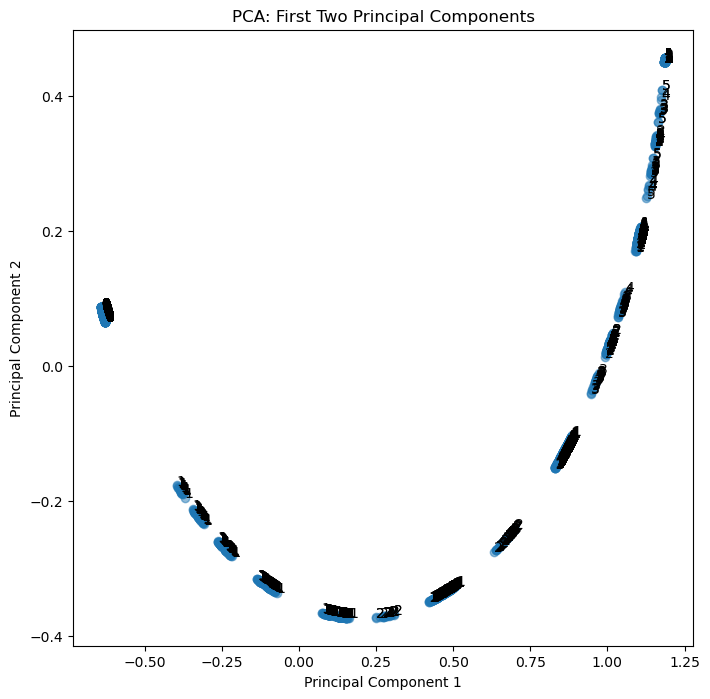

In [127]:


# You can also use PCA to reduce dimensionality by specifying the number of components
n_components = 2  # Adjust the number of components as needed
pca = PCA(n_components=n_components)
reduced_matrix = pca.fit_transform(n)

# 'reduced_matrix' now contains the data with reduced dimensions

# Optionally, you can visualize the first two principal components
if n_components >= 2:
    plt.figure(figsize=(8, 8))
    plt.scatter(reduced_matrix[:, 0], reduced_matrix[:, 1], alpha=0.5)
    for i in range(len(reduced_matrix)):
        plt.text(reduced_matrix[i, 0], reduced_matrix[i, 1], data["output"][i])
    plt.xlabel('Principal Component 1')
    plt.ylabel('Principal Component 2')
    plt.title('PCA: First Two Principal Components')
    plt.show()

In [129]:


n_components = 20  # Adjust the number of components as needed
pca = PCA(n_components=n_components)
reduced_matrix = pca.fit_transform(n)

# 'reduced_matrix' now contains the data with reduced dimensions

# Optionally, you can visualize the first two principal components
if n_components >= 2:
    plt.figure(figsize=(8, 8))
    plt.scatter(reduced_matrix[:, 0], reduced_matrix[:, 1], alpha=0.5)
    for i in range(len(reduced_matrix)):
        plt.text(reduced_matrix[i, 0], reduced_matrix[i, 1], data["output"][i])
    plt.xlabel('Principal Component 1')
    plt.ylabel('Principal Component 2')
    plt.title('PCA: First Two Principal Components')
    plt.show()

SyntaxError: invalid syntax (793594265.py, line 1)

In [124]:
print(reduced_matrix.shape)

(3110, 10)


In [136]:
colors=[]
for i in range(3110):
    a = data["output"][i]
    if a == 4 or a == 5 or a == 6 or a == 7:
        colors.append('r')
    elif a== 2 or a == 3:
        colors.append('b')
    else:
        colors.append('g')


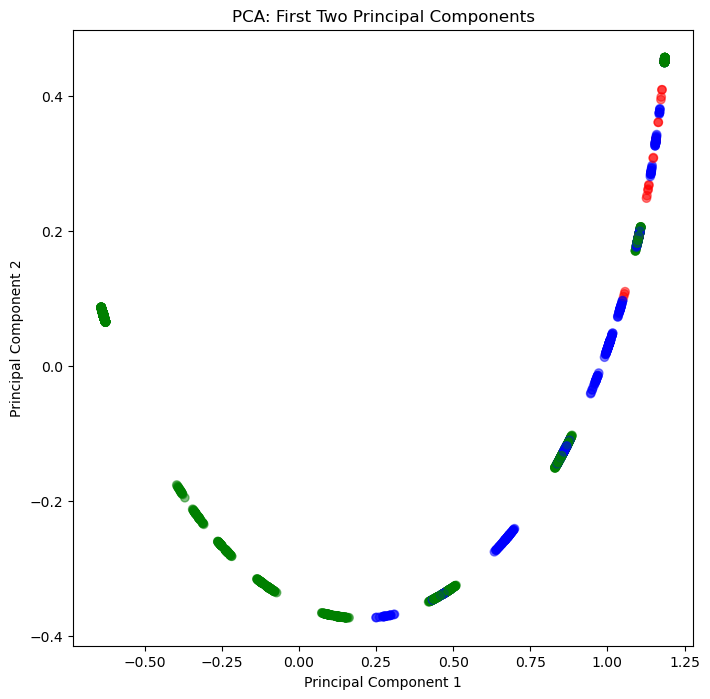

In [137]:
n_components = 5  # Adjust the number of components as needed
pca = PCA(n_components=n_components)
reduced_matrix = pca.fit_transform(n)

# 'reduced_matrix' now contains the data with reduced dimensions

# Optionally, you can visualize the first two principal components
if n_components >= 2:
    plt.figure(figsize=(8, 8))
    plt.scatter(reduced_matrix[:, 0], reduced_matrix[:, 1], c=colors, alpha=0.5)
    
    plt.xlabel('Principal Component 1')
    plt.ylabel('Principal Component 2')
    plt.title('PCA: First Two Principal Components')
    plt.show()

In [138]:
import numpy as np
from sklearn.linear_model import LinearRegression

# Sample list of input vectors (features), each of size 512
input_vectors = []  # Replace this with your actual list of input vectors

# Sample list of target outputs (labels)
target_outputs = []  # Replace this with your actual list of target outputs

# Convert input vectors and target outputs to NumPy arrays
X = n
y = np.array(data['output'])

# Create a linear regression model
model = LinearRegression()

# Fit the model to the data (learn the linear combination)
model.fit(X, y)

# Get the learned coefficients (linear combination)
coefficients = model.coef_

# Get the intercept (bias)
intercept = model.intercept_

# Make predictions using the learned model
predictions = model.predict(X)

# Print the coefficients, intercept, and predictions
print("Learned Coefficients (Linear Combination):", coefficients)
print("Intercept (Bias):", intercept)
print("Predictions:", predictions)


Learned Coefficients (Linear Combination): [-4.53691133e+04 -4.66747559e+02 -2.59673401e+02  3.09560303e+02
  5.00809692e+02 -3.18878418e+02  1.79328125e+02  6.82981445e+02
  2.43446777e+02  7.27922485e+02 -8.61426758e+02  1.56658691e+02
  4.77865143e+02  1.42139221e+02 -3.47277527e+02  2.28197479e+01
 -4.52677826e+02  8.10927490e+02 -1.49234039e+02 -3.83490356e+02
 -3.39303955e+02 -1.85658798e+02 -1.54066504e+03  4.87653473e+02
 -8.43586670e+02  5.48730408e+02  3.55603699e+02 -1.71002670e+02
  3.47831360e+02 -2.23278381e+02  8.41604248e+02  1.12705798e+03
 -7.69207825e+02 -5.29374634e+02  7.31781982e+02 -2.53497971e+02
 -2.76758118e+02 -9.12120850e+02  1.14544678e+02 -9.97686646e+02
  9.53642090e+02  1.41317490e+02 -1.11056165e+03 -1.45521210e+02
  8.34245605e+02  4.97101593e+00 -1.31338959e+02 -1.47199512e+03
  7.34172729e+02 -6.70887512e+02 -3.90766754e+02  4.07536865e+02
  1.89593811e+02 -7.64302429e+02 -1.86172562e+02 -1.59367599e+02
  9.25867737e+02  2.50543716e+02  3.03809509e+0

In [140]:
from sklearn.metrics import r2_score

r_squared = r2_score(y, predictions)

In [141]:
print(r_squared)

0.6948399189220849
